In [182]:
from typing import Callable, List
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from numpy import ndarray

plt.rcParams["figure.figsize"] = (20,10)

In [332]:
"""
Finds gradient of function fun in point x with precision h.
"""
def grad(fun:Callable[[ndarray], float], x:ndarray, h:float=1e-5) -> ndarray:
    dim = len(x)
    g = np.zeros(dim)
    step = np.zeros(dim)
    for i in range(dim):
        step[i] = h
        g[i] = (fun(x + step) - fun(x - step)) / (2 * h)
        step[i] = 0
    return g

"""
Finds "partial" gradient of function represented in the form of sum.
Calculates sum of derivatives of some terms of function fun in a row.

@param fun: list of terms of the function to find partial gradient for
@param x: point in which derivatives are calculated
@param r: list of 2 elements. 1 element shows the first term in list fun for which gradiant will be found. 2 element shows for how many terms after first term gradient will be found
@param h: precision of calculated gradients

@returns r[1] dimensional list containing sum of calculated gradients
"""
def grad_appr(fun:List[Callable[[ndarray], float]], x:ndarray, r:List=(0, 1), h:float=1e-5) -> ndarray:
    sum = np.zeros(len(x))
    begin = r[0]
    n = r[1]
    for i in range(n):
        sum += grad(fun[(begin + i) % len(fun)], x, h)
    return sum

"""
Generates cartesian product of points in arrays.

Это функция взята с Stack Overflow, я понятия не имею, как она работает, и не хочу иметь.
"""
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

"""
Generates data set for multiple linear regression.
Guaranteed that expected value of noise equals to 0. Every regressor is len(b) - 1 dimensional vector.
Both regressors and dependent variables lists has size equals to len(t) ** (len(b) - 1).


Для облегчения понимания можно считать, что функция генерирует точки, смещённые относительно некоторой гиперплоскости вверх или вниз.

p[1:] в некотором роде задаёт нормаль к этой гиперплоскости. p[0] - смещение гиперплоскости вверх или вниз относительно начала координат, length - её длина. k или шум характеризует то, насколько сгенерированные точки будут отклоняться от гиперплоскости, которую мы приближаем. num - количество точек на гиперплоскости.

В итоге получается два массива: точки на гиперплоскости и высоты этих точек.


@param b: list characterising linear relationship between regressors (independent variables) and dependent variable. b[0] is dependent variable offset
@param k: noise (error term) max absolute value
@param t: list describing basis linspace for dataset

@return list of two elements: list of regressors and list of dependent values
"""
def generate_dataset(b:List, k:int, t:ndarray = np.linspace(0, 10, 50)) -> List[List]:
    # t += (np.random.rand(len(t)) - 0.5) * 2 * k
    h, b = b[0], b[1:]
    dim = len(b)
    # *[t]*dim is equals to *np.tile(t, dim).reshape((dim, -1))
    regressors = cartesian_product(*[t]*dim)
    # Noise
    e = (np.random.rand(len(regressors)) - 0.5) * 2 * k
    dependent_var = (b * cartesian_product(*[t]*dim)).sum(axis=1) + h + e
    return [regressors, dependent_var]

"""
Generates function which minimum point is the solution for linear regression problem for dataset [t, ft].
It is pretty slow.

@return list of terms of generated function
"""
def generate_minimized_fun(t:List, ft:List) -> List[Callable[[List], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i] and ft[i] from current context
        sum_fun[i] = partial(lambda t, ft, a: 1 / len(t) * np.square(a[0] + np.sum(a[1:] * t) - ft), t[i], ft[i])
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Finds minimum of the function sum_fun using stochastic gradient descent (sgd).

@return list of points representing path of sgd. The last point of the list is found minimum point.
"""
def sgd(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    points = np.zeros([epoch, len(x)])
    points[0] = x
    for i in range(1, epoch):
        x = x -  np.array([1 / batch_size]) * scheduler(lr) * np.array(grad_appr(sum_fun, x, [i, batch_size]))
        points[i] = x
    return points

## Решение задачи простой линейной регрессии (одномерное пространство регрессоров)
Приближает прямую в двумерном пространстве

[8.19424627 4.92299181]
[[0.         0.        ]
 [0.71558996 1.38985693]
 [1.41024635 2.39004484]
 [2.09139698 3.10432934]
 [2.74058993 3.61527921]
 [3.35584973 3.98063041]
 [3.92470943 4.23487228]
 [4.45201346 4.41724265]
 [4.9343797  4.55091696]
 [5.37461237 4.6480227 ]
 [5.78309685 4.7178857 ]
 [6.1554694  4.76995278]
 [6.49517262 4.80540517]
 [6.80950395 4.83187673]
 [7.09114318 4.85482571]
 [7.35819592 4.87807288]
 [7.60643169 4.89250548]
 [7.82373227 4.90505493]
 [8.01906862 4.91599092]
 [8.19424627 4.92299181]]


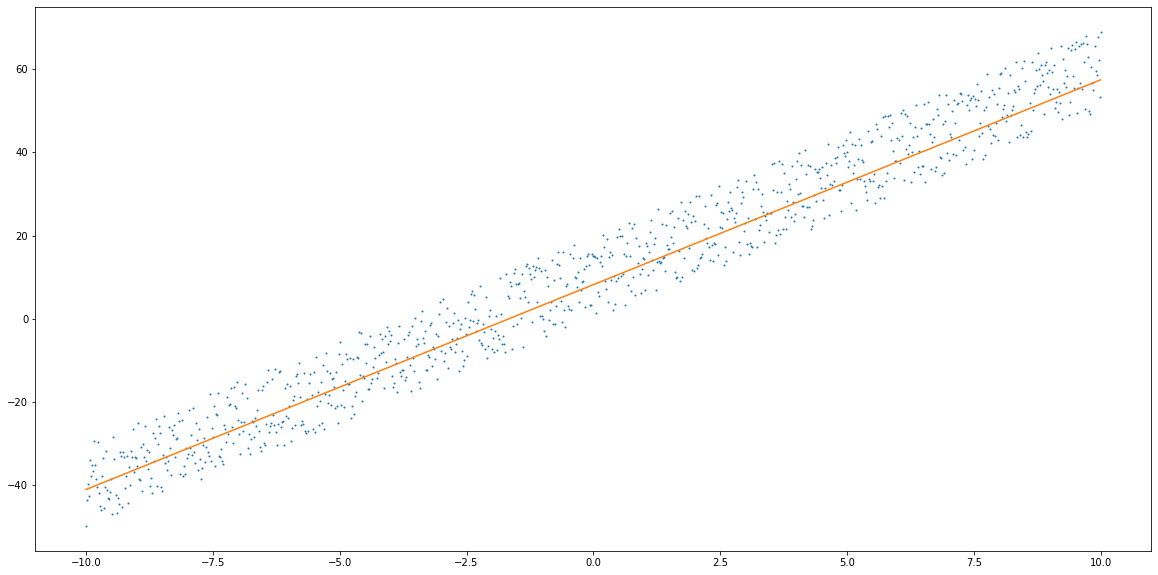

In [334]:
tt = np.linspace(-10, 10, 1000)
p = [10, 5]
t, ft = generate_dataset(p, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 150
lr = [0.05, 0.004]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(min_point)
print(points)

# Plots dataset
plt.plot(t, ft, 'o', markersize=1)
# Plots approximated function
plt.plot(tt, min_point[1] * tt + min_point[0])

## Решение задачи линейной регрессии (для двумерного пространства регрессоров)
Приближает плоскость в трёхмерном пространстве

[9.5342277  2.21922253 3.83951077]
[[0.         0.         0.        ]
 [0.55054015 0.19695198 0.61980789]
 [0.97597102 0.39882248 1.18636837]
 [1.30704493 0.5909861  1.6864434 ]
 [1.58917451 0.73472271 2.10335669]
 [1.87495856 0.86514973 2.43952992]
 [2.16071074 0.97910899 2.73176811]
 [2.40249223 1.07216421 2.92094999]
 [2.69227458 1.1654414  3.13357486]
 [2.94993435 1.22982949 3.30511478]
 [3.22454808 1.29887738 3.45976369]
 [3.52805039 1.35462248 3.60420909]
 [3.85494803 1.41318632 3.72523412]
 [4.17834843 1.47338857 3.86387634]
 [4.48942656 1.52204053 3.9596523 ]
 [4.78767012 1.56762158 4.01993502]
 [5.09704481 1.6226147  4.06518996]
 [5.42115857 1.67535577 4.09674559]
 [5.70876011 1.72418514 4.11929081]
 [5.94086163 1.76328932 4.13238834]
 [6.15503095 1.80043371 4.13040542]
 [6.35684213 1.83613362 4.1355849 ]
 [6.56113138 1.8634328  4.1308845 ]
 [6.73731485 1.90141425 4.13531668]
 [6.91748839 1.93864584 4.14849672]
 [7.09460367 1.97993237 4.15134219]
 [7.30619179 2.01423728 4.160

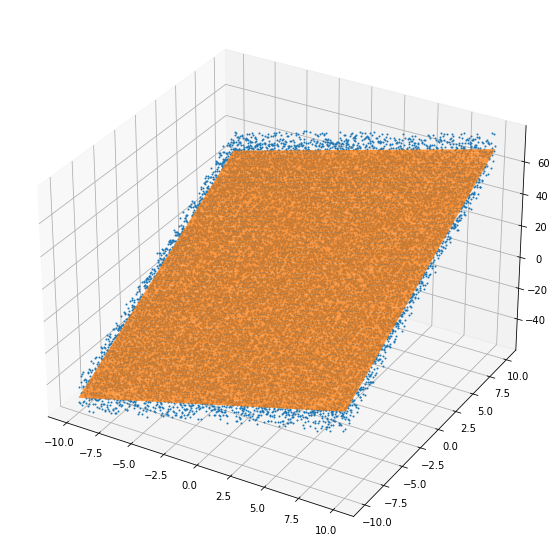

In [333]:
tt = np.linspace(-10, 10, 150)
b = [10, 2, 4]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
batch_size = 20
lr = [0.05, 0.002, 0.004]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(min_point)
print(points)

ax = plt.figure().add_subplot(projection='3d')
# Plots dataset
ax.plot(t[:, 0], t[:, 1], ft, 'o', markersize=1)
# Plots approximated function
X, Y = np.meshgrid(tt, tt)
ax.plot_surface(X, Y, min_point[0] + min_point[1] * X + min_point[2] * Y, alpha=0.8)

## 4-мерное пространство регрессоров

In [336]:
tt = np.linspace(-10, 10, 20)
b = [10, 2, 4, 5, -3]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(5)
epoch = 50
batch_size = 3
lr = [0.1, 0.002, 0.004, 0.005, 0.003]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(min_point - b)
print(min_point)
print(points)

[ 0.06228152 -0.25760794  0.15898024 -0.07804067 -0.13498931]
[10.06228152  1.74239206  4.15898024  4.92195933 -3.13498931]
[[ 0.          0.          0.          0.          0.        ]
 [ 2.16772992  0.1423503   0.1295927   0.52211612 -0.23601616]
 [ 2.81413737  0.28437227  0.43078312  0.5684355  -0.34925683]
 [ 1.7798399   0.72722669  1.06562869  1.25007358 -0.83249197]
 [ 0.12374188  1.02228306  1.55172989  1.559021   -1.24582518]
 [-1.77840038  1.33198367  2.18929347  2.04350916 -1.69485177]
 [-1.32051956  1.61355476  2.30716462  2.60864923 -2.08374601]
 [-0.97998043  1.83682289  2.40447187  3.07244249 -2.40705998]
 [ 0.33074481  2.0066298   2.57474571  3.41276562 -2.51310229]
 [ 1.37135147  1.99854945  2.7430784   3.61912414 -2.40648877]
 [ 2.73504895  2.03057159  2.84859071  4.00176364 -2.40135849]
 [ 3.94711946  2.01108509  2.84174425  4.45505838 -2.52669919]
 [ 4.79242487  2.00866816  2.91957393  4.6837747  -2.62756306]
 [ 5.71983282  1.94746378  3.18017888  4.85589736 -2.7862

## Сходимость в зависимости от размера batch
Двумерное пространство регрессоров

[[0.0443171  0.01720201 0.01104772]
 [0.03170308 0.03248989 0.01812381]
 [0.03016419 0.05751507 0.01963733]
 [0.02987629 0.06631667 0.01640141]
 [0.02985969 0.08181309 0.01499218]
 [0.02629364 0.08672242 0.01537717]
 [0.02204996 0.09124462 0.01314787]
 [0.0200967  0.10889835 0.00973036]
 [0.01813251 0.12477733 0.00685231]
 [0.01593285 0.13809875 0.00524238]
 [0.01529077 0.14704799 0.00262665]
 [0.01486653 0.15603581 0.00089223]
 [0.01323089 0.15298575 0.00107235]
 [0.01201654 0.15006824 0.00249673]
 [0.01116931 0.14774075 0.00365205]
 [0.01168624 0.1407691  0.00616752]
 [0.01109913 0.13225398 0.00859004]
 [0.00990178 0.12895432 0.01076632]
 [0.00862313 0.12673644 0.01249353]
 [0.00728705 0.12476206 0.01389062]
 [0.00654533 0.12506085 0.01551424]
 [0.0061566  0.12559527 0.01642177]
 [0.00506979 0.12708975 0.01717464]
 [0.00459725 0.1297201  0.01824083]
 [0.00389713 0.1316     0.01924781]
 [0.00372007 0.13130116 0.0201565 ]
 [0.00388137 0.12914782 0.02067511]
 [0.00412959 0.12653981 0.02

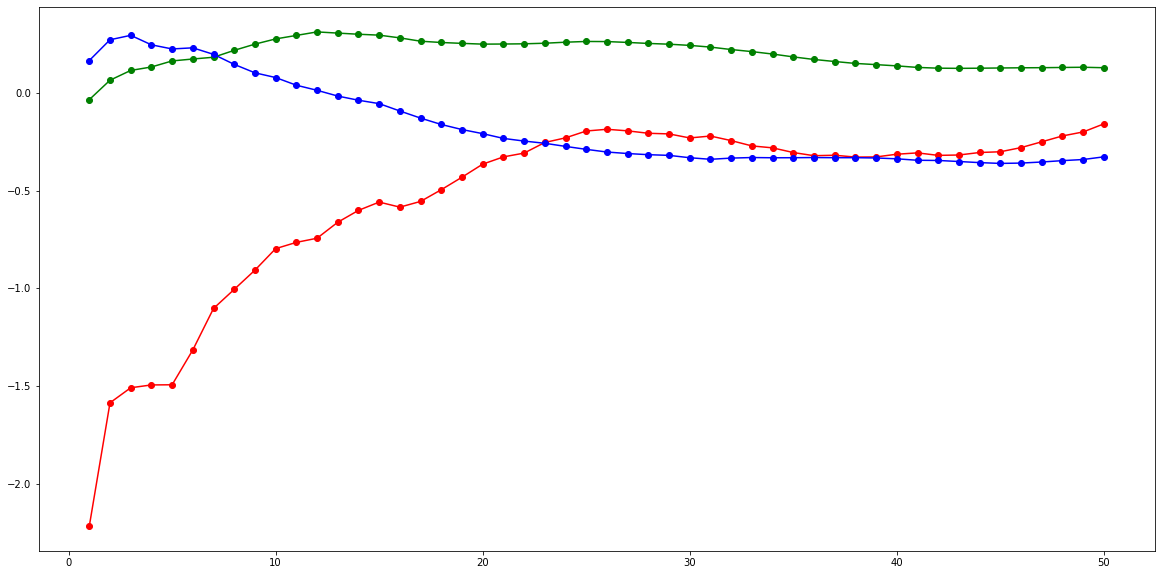

In [338]:
tt = np.linspace(-10, 10, 10)
b = [50, 2, 15]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
batch_size = 20
lr = [0.09, 0.002, 0.004]
scheduler = lambda lr: np.array(lr) * np.exp(-0.01)

# n <= np.power(len(tt), 2)
n = 50
min_points = []
for batch_size in range(1, n + 1):
    min_points.append(sgd(sum_fun, x, epoch, batch_size, lr, scheduler=scheduler)[-1])

min_points = np.array(min_points)
print(np.abs((b - min_points) / b))
print(min_points)

plt.plot(np.linspace(1, n, n), (b - min_points)[:, 0], '-o', color='red')
plt.plot(np.linspace(1, n, n), (b - min_points)[:, 1], '-o', color='green')
plt.plot(np.linspace(1, n, n), (b - min_points)[:, 2], '-o', color='blue')

## Старый код

## Генерация точек рядом с прямой в 3-мерном пространстве

[[-2.06855936  0.6772899 ]
 [-0.56721548  1.2637922 ]
 [ 2.36611266  0.81144625]
 [ 0.86855488 -1.89902341]
 [-2.28915561 -1.27447443]
 [ 1.36913793  1.22856328]
 [-1.03271406  0.02966839]
 [-0.05724863 -0.37193637]
 [ 0.49517875 -0.93921862]
 [-1.74662716 -0.12945644]
 [ 2.3416286   2.08451794]
 [-0.24346115 -0.1348261 ]
 [-0.24555271 -0.6319812 ]
 [ 0.69480899  2.13336113]
 [ 1.89616961 -0.49850871]
 [-0.63720461 -0.37030474]
 [ 1.25499889  0.51551581]
 [-2.29881904  1.46726783]
 [ 1.73577332 -0.20278357]
 [-1.19600406 -1.87779857]
 [ 0.25228623 -1.23492006]
 [ 1.96541217  2.02502295]
 [-0.08036444 -0.55072917]
 [-1.30392002  2.40934519]
 [-0.61566212 -0.22193898]
 [-0.86520218 -0.65436414]
 [-1.00568584 -1.82061323]
 [-0.88000776  0.24137786]
 [ 0.20661538  0.57380568]
 [ 0.35752545  1.68085652]
 [ 0.19200395  2.4660895 ]
 [ 1.79856135 -1.63264978]
 [ 1.40766108 -0.78234978]
 [-0.36362228 -0.74105641]
 [ 0.63151693 -0.34219276]
 [-2.0165067  -1.79528918]
 [-1.11904619 -1.57631465]
 

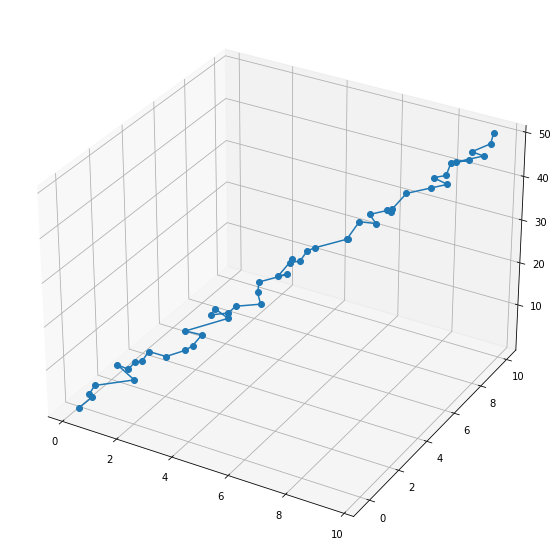

In [186]:
# dim - размерность пространства факторов (размерность пространства - 1)
# t - длина прямой
# p - направляющий вектор прямой
# k - коэффициент отклонения от заданной прямой

dim = 2
tt = np.linspace(0, 10, 50)
p = np.array([1, 1])
k = 1
t = tt.repeat(dim).reshape(len(tt), dim) * np.tile(p, len(tt)).reshape((len(tt), dim)) + (np.random.rand(len(tt), dim) - 0.5) * k
print((np.random.rand(len(tt), dim) - 0.5) * 5)
ft = 5 * tt + (np.random.rand(len(tt)) - 0.5) * k

ax = plt.figure().add_subplot(projection='3d')
ax.plot(t[:, 0], t[:, 1], ft, 'o-')

Generation of function complete!
[[ 0.          0.        ]
 [ 6.13598116 14.36072261]
 [ 3.66223489  9.75851048]
 [ 4.46939163 12.37421542]
 [ 4.04624873 12.34448581]
 [ 4.09117894 13.24576267]
 [ 3.91742756 13.63084975]
 [ 3.87836505 14.24126038]
 [ 3.78877586 14.6586559 ]
 [ 3.72901292 15.13474365]
 [ 3.63944919 15.4333944 ]
 [ 3.61880064 15.86830618]
 [ 3.53822331 16.12644234]
 [ 3.48646355 16.42254526]
 [ 3.42178347 16.62900008]
 [ 3.42815842 16.96266397]
 [ 3.37513354 17.10690029]
 [ 3.34421484 17.24626431]
 [ 3.28787469 17.3152582 ]
 [ 3.26124532 17.43409219]]
[ 3.26124532 17.43409219]


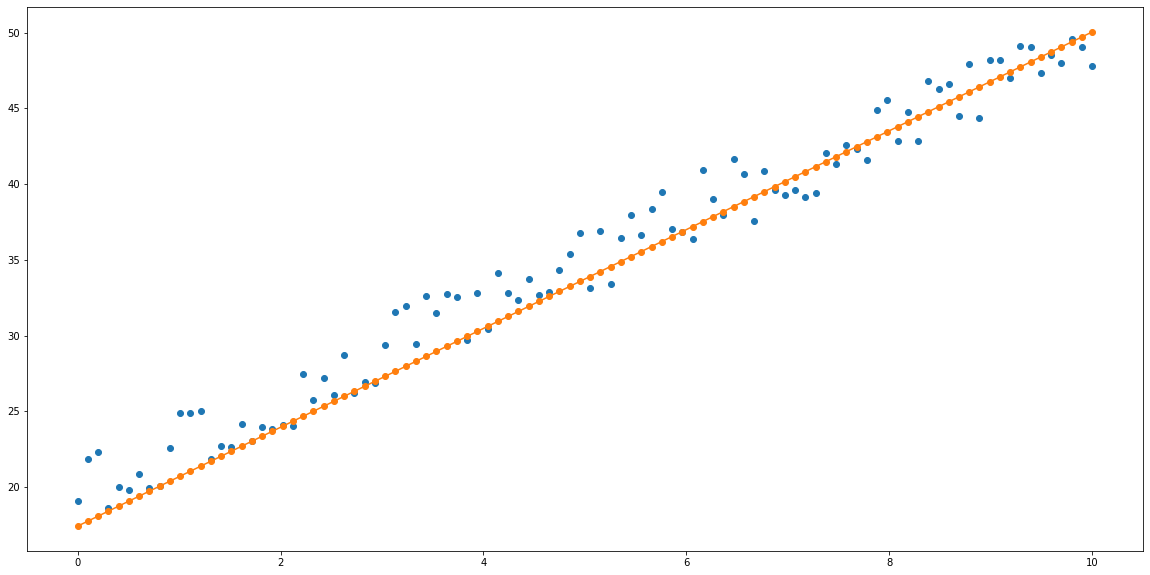

In [187]:
"""
Generates data set for multiple linear regression.
Guaranteed that expected value of noise equals to 0. Every regressor is len(p) - 1 dimensional vector.
Every dependent variable is integer. Both regressors and dependent variables lists has size equals to num.


Для облегчения понимания можно считать, что функция генерирует точки, смещённые относительно некоторый прямой вврех и вниз.

p это направляющий вектор прямой, которую мы приближаем. h - смещение этой прямой, length - её длина. k характеризует то, насколько сгенерированные точки будут отклоняться от прямой, которую мы приближаем. num - количество этих точек.

В итоге получается два массива: точки выстроенные вдоль прямой на гиперплоскости и высоты этих точек, смещённые на некоторый число.


@param p: linear relationship between independent variables (regressors) and dependent variable (measured variable)
@param h: dependent variable offset
@param k: noise (error term) max absolute value
@param length: describe length of data set
@param num: number of points in data set

@return list of two elements: list of regressors and list of dependent values
"""
def generate_dataset(p:List, h:int, k:int, length:int = 10, num:int = 50) -> List[List]:
    dim = len(p) - 1
    t = np.linspace(0, length, num)
    regressors = t.repeat(dim).reshape(len(t), dim) * np.tile(p[0:dim], len(t)).reshape((len(t), dim))
    dependent_var = p[dim] * t + h + (np.random.rand(len(t)) - 0.5) * 2 * k
    return [regressors, dependent_var]

# Initial data
t = np.linspace(0, 10, 100)
ft = 3 * t + (np.random.rand(len(t)) - 0.5) * 5 + 20

# Generation of optimized function (it's really slow)
sumFun = np.empty(len(t), dtype=partial)
j = 0
while j < len(t):
    # Captures t[j] and ft[j] from current context
    sumFun[j] = partial(lambda t, ft, a: np.square(a[0] * t + a[1] - ft), t[j], ft[j])
    j += 1

print("Generation of function complete!")

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
# Функция растёт по второй переменной медленнее, чем по первой, поэтому с текущим lr минимум, найденный для второй переменной, неточен. Если повысить lr, то начнут происходить слишком сильные скачки производной по первой переменной. Лучше всего было сделать различный lr для первой и для второй переменной
lr = [0.0007, 0.01]

np.random.shuffle(sumFun)

points = np.zeros((epoch, len(x)))
points[0] = x
for i in range(1, epoch):
    x = x - lr * np.array(grad_appr(sumFun, x, [i, batch_size]))
    points[i] = x

print(points)

print(x)

plt.plot()
plt.plot(t, ft, 'o')
plt.plot(t, (lambda p: x[0] * p + x[1])(t), '-o')